In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns



# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | tree status in year 1 post-fire 
| YrFireName                  | Year and name of the fire                                    
| Times_burned                | The number of times this tree was burned                                             
| Species                     |  Symbol for species. First two letters of genus and first two letters of species, sometimes followed by a number. Symbols follow those in the PLANTS National Database                                                   
| Genus_species               | Genus and species of tree                                      
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm 
| HT_m                        | Pre-fire tree height rounded to nearest 0.01 m
| CR_pre                      | Pre-fire live crown ratio. Crown length divided by tree height
| CR_post                     | Post-fire live crown ratio. Crown length divided by tree height 

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')
trees_dat = trees_dat[['yr1status', 'YrFireName', 'Times_burned', 'Species', 'Genus_species',
    'DBH_cm', 'HT_m', 'CR_pre', 'CR_post']]
trees_dat = trees_dat.dropna()
print(f'Number of observations: {trees_dat.shape[0]}')

Number of observations: 36509


/tmp/ipykernel_1382416/741259085.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [3]:
for col in ['YrFireName', 'Species', 'Genus_species']:
    trees_dat[f"{col}_int"] = trees_dat[col].astype('category').cat.codes
    
# Check
trees_dat.head()

,yr1status,YrFireName,Times_burned,Species,Genus_species,DBH_cm,HT_m,CR_pre,CR_post,YrFireName_int,Species_int,Genus_species_int
500,0.0,2003 - Griff,1,ABAM,Abies_amabilis,71.374,41.76,0.84,0.74,37,0,0
501,0.0,2003 - Griff,1,ABAM,Abies_amabilis,23.622,12.80,0.60,0.57,37,0,0
502,0.0,2003 - Griff,1,ABAM,Abies_amabilis,46.228,34.75,0.75,0.59,37,0,0
503,0.0,2003 - Griff,1,ABAM,Abies_amabilis,21.082,23.16,0.38,0.38,37,0,0
504,0.0,2003 - Griff,1,ABAM,Abies_amabilis,24.384,26.21,0.42,0.42,37,0,0


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [4]:
# Assign predictor and outcome variables 
X = trees_dat[['Times_burned', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post', 'YrFireName_int', 'Species_int', 'Genus_species_int']]
y = trees_dat[['yr1status']]

# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit and transform
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [5]:
# Verify the training and testing set size
print("Training set observations:", X_train_scaled.shape[0])
print("Testing set observations:", X_test_scaled.shape[0])

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [13]:
# Create the logistic regression classifier
classifier = LogisticRegression()

# Fit the model on the scaled training data
classifier.fit(X_train_scaled, y_train)  

# Make predictions on the training data
y_train_pred = classifier.predict(X_train_scaled)

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy}")

Training accuracy: 0.945061825011739


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 0.9401990322286131


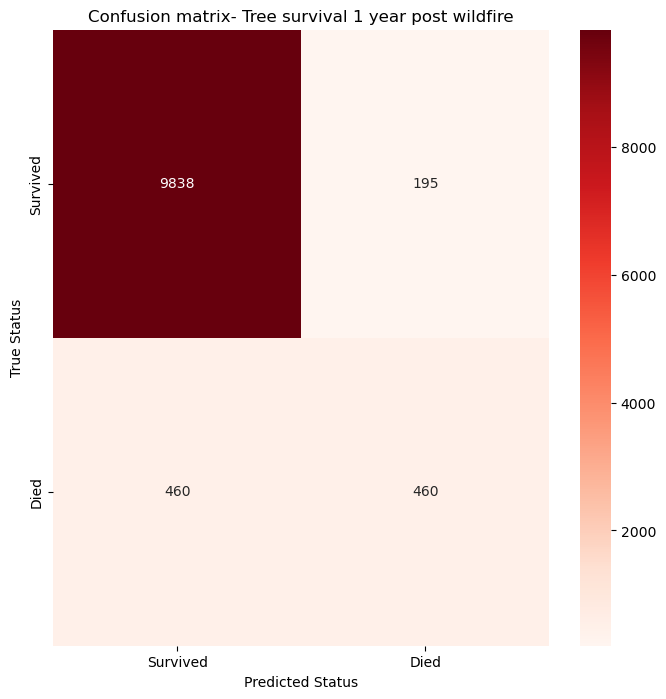

In [14]:
# Make predictions on test set
y_test_pred = classifier.predict(X_test_scaled)

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Survived', 'Died'],
            yticklabels=['Survived', 'Died'])
plt.title('Confusion matrix- Tree survival 1 year post wildfire')
plt.ylabel('True Status')
plt.xlabel('Predicted Status')
plt.show()


## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

At first glance it appears the model performed well on the unseen data because the large majority of results were true positives and it was correct about 94% of the outputs. However once we look deeper into the results we can see that for trees that survived the predicted status was correct about 98% of the time but for trees that died, the predicted status was correct ony about 47% of the time. So our model performed much better on trees that survived vs trees that died. There is a class imbalance in the dataset. About 92% of the trees survived the first year and only about 8% died. 

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (alive trees)? How would its accuracy compare to your logistic regression model?

I think if we built a model that always predicted the majority class it would be pretty accurate due to the fact that about 95% of the trees survived, so it would be a true positive most of the time. It would only perform slightly less well than our logistic regression model with about 92% accuracy.

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy: 0.92

Dummy Confusion Matrix: 


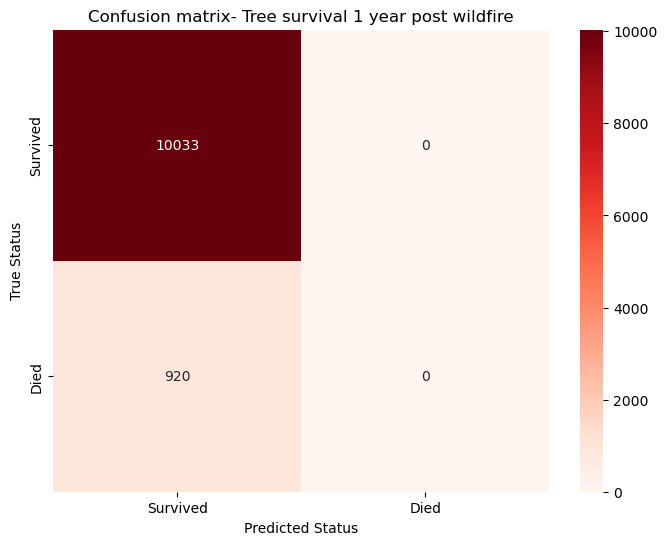

In [8]:
# Train majority classifier
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train_scaled, y_train)

# Make predictions
dummy_train_pred = dummy_classifier.predict(X_train_scaled)
dummy_test_pred = dummy_classifier.predict(X_test_scaled)


# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {accuracy_score(y_train, dummy_train_pred):.2f}")
print("\nDummy Confusion Matrix: ")

dummy_cm = confusion_matrix(y_test, dummy_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(dummy_cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Survived', 'Died'],
            yticklabels=['Survived', 'Died'])
plt.title('Confusion matrix- Tree survival 1 year post wildfire')
plt.ylabel('True Status')
plt.xlabel('Predicted Status')
plt.show()

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [9]:
# Logistic classifier AUC
lr_probs = classifier.predict_proba(X_test_scaled)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print(f"Logistic AUC: {lr_auc:.2f}")

Logistic AUC: 0.92


In [10]:
# Dummy classifier AUC
dummy_probs = dummy_classifier.predict_proba(X_test_scaled)[:, 1]
dummy_auc = roc_auc_score(y_test, dummy_probs)
print(f"Dummy AUC: {dummy_auc:.2f}")

Dummy AUC: 0.50


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

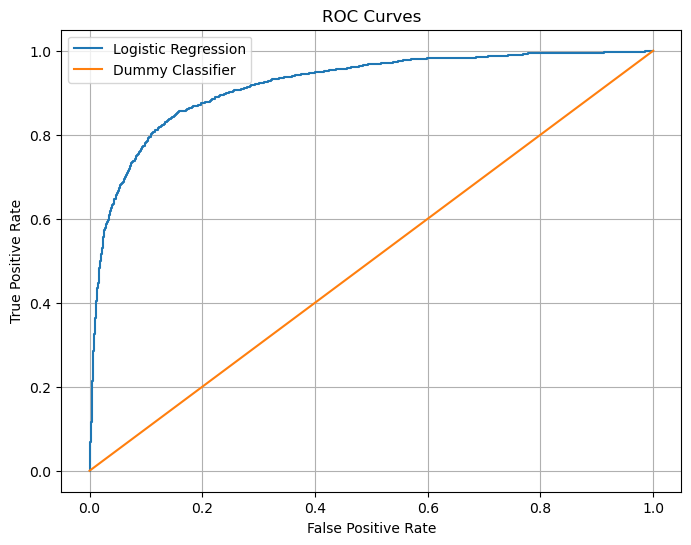

In [11]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
dummy_fpr, dummy_tpr, _ = roc_curve(y_test, dummy_probs)


# Create the ROC plot
plt.figure(figsize=(8, 6))

plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.plot(dummy_fpr, dummy_tpr, label='Dummy Classifier')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The logistic regression model performs much better than the dummy classifier when comparing AUC. This shows that accuracy of predictions can me misleading when we have class imbalance. Our ROC and AUC gave a more representative performance description.

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [12]:
# Create df with features and coefficients
feature_names = X.columns.tolist()
coefficients = classifier.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficient
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
importance_df = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Print the sorted feature importance
print(importance_df)

             Feature  Coefficient  Abs_Coefficient
4            CR_post    -2.494974         2.494974
2               HT_m    -1.165414         1.165414
5     YrFireName_int    -0.660497         0.660497
6        Species_int     0.541509         0.541509
1             DBH_cm     0.421324         0.421324
3             CR_pre     0.123414         0.123414
7  Genus_species_int    -0.067867         0.067867
0       Times_burned     0.000000         0.000000


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

The post-fire live crown ratio was the most important feature in our model, followed by pre-fire tree height rounded to nearest 0.01 m. One forest management strategy could be to make sure trees are spaced out well, as crown ratio is a very important feature. Using these two features, certain areas could also be prioritized for protection during fires to increase survival.